In this project, we will use the Resnet that we trained to annotate images.
The image annotations consist of bounding boxes which envelope a single object and labels for each object in the bounding box. Our training set is given by COCO 2014.

Our first task is to modify the the neural network that we trained in file 1 to be adapted for the much smaller list of classes in COCO. COCO consists of 80 categories:

person, bicycle, car, motorcycle, airplane, bus, train, truck, boat, traffic_light, fire_hydrant, stop_sign, parking_meter, bench, bird, cat, dog, horse, sheep, cow, elephant, bear, zebra, giraffe, backpack, umbrella, handbag, tie, suitcase, frisbee, skis, snowboard, sports_ball, kite, baseball_bat, baseball_glove, skateboard, surfboard, tennis_racket, bottle, wine_glass, cup, fork, knife, spoon, bowl, banana, apple, sandwich, orange, broccoli, carrot, hot_dog, pizza, donut, cake, chair, couch, potted_plant, bed, dining_table, toilet, tv, laptop, mouse, remote, keyboard, cell_phone, microwave, oven, toaster, sink, refrigerator, book, clock, vase, scissors, teddy_bear, hair_drier, toothbrush

In order to facilitate the smaller class, set we we freeze the hidden layers of the network and learn the fully connected output layer.


In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class BasicBlock(nn.Module):
    expansion = 1

    def __init__(self, in_channels, out_channels, stride=1, downsample=None):
        super(BasicBlock, self).__init__()
        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=stride, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(out_channels)
        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(out_channels)
        self.downsample = downsample

    def forward(self, x):
        identity = x
        if self.downsample is not None:
            identity = self.downsample(x)

        out = self.conv1(x)
        out = self.bn1(out)
        out = F.relu(out)

        out = self.conv2(out)
        out = self.bn2(out)

        out += identity
        out = F.relu(out)

        return out

class ResNet(nn.Module):
    def __init__(self, block, layers, num_classes=1000):
        super(ResNet, self).__init__()
        self.in_channels = 64
        self.conv1 = nn.Conv2d(3, 64, kernel_size=7, stride=2, padding=3, bias=False)
        self.bn1 = nn.BatchNorm2d(64)
        self.relu = nn.ReLU(inplace=True)
        self.maxpool = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)

        self.layer1 = self._make_layer(block, 64, layers[0])
        self.layer2 = self._make_layer(block, 128, layers[1], stride=2)
        self.layer3 = self._make_layer(block, 256, layers[2], stride=2)
        self.layer4 = self._make_layer(block, 512, layers[3], stride=2)

        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))
        self.fc = nn.Linear(512 * block.expansion, num_classes)

    def _make_layer(self, block, out_channels, blocks, stride=1):
        downsample = None
        if stride != 1 or self.in_channels != out_channels * block.expansion:
            downsample = nn.Sequential(
                nn.Conv2d(self.in_channels, out_channels * block.expansion,
                          kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(out_channels * block.expansion),
            )

        layers = []
        layers.append(block(self.in_channels, out_channels, stride, downsample))
        self.in_channels = out_channels * block.expansion
        for _ in range(1, blocks):
            layers.append(block(self.in_channels, out_channels))

        return nn.Sequential(*layers)

    def forward(self, x):
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.maxpool(x)

        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)

        x = self.avgpool(x)
        x = torch.flatten(x, 1)
        x = self.fc(x)

        return x

def resnet18(num_classes=1000):
    return ResNet(BasicBlock, [2, 2, 2, 2], num_classes)
    

In [2]:
import subprocess
from pathlib import Path
import torch

# Get Git repository root dynamically
repo_root = subprocess.check_output(['git', 'rev-parse', '--show-toplevel'], text=True).strip()

# Define path relative to Git repo root
weights_path = Path(repo_root) / "resnet18_weights.pth"

#weights_path = '/home/ryan/Deep_Learning/resnet18_weights.pth'
print(f"Loading weights from: {weights_path}")

num_coco_classes = 80  # Adjust for your dataset
model = ResNet(BasicBlock, [2, 2, 2, 2], num_classes=num_coco_classes)

# Load the checkpoint, but ignore incompatible layers
checkpoint = torch.load(weights_path, map_location='cpu')

# Remove the fc layer weights from the loaded checkpoint
del checkpoint['fc.weight']
del checkpoint['fc.bias']

# Load the model ignoring the fc layer
model.load_state_dict(checkpoint, strict=False)

print("Model loaded, but fc layer was ignored due to size mismatch.")

# Define new fully connected layer with correct number of classes
model.fc = nn.Linear(model.fc.in_features, num_coco_classes)

# Move model to the appropriate device (GPU if available)
device = torch.device("mps")
model = model.to(device)

print("Model loaded and transferred to:", device)


# Freeze all layers except the last block and fc
for name, param in model.named_parameters():
    if 'layer4' not in name and 'fc' not in name:
        param.requires_grad = False

for name, param in model.named_parameters():
    if param.requires_grad:
        print(f"Training: {name}")
    else:
        print(f"Frozen: {name}")

Loading weights from: /Users/ryanaschoff/Deep_Learning/resnet18_weights.pth
Model loaded, but fc layer was ignored due to size mismatch.
Model loaded and transferred to: mps
Frozen: conv1.weight
Frozen: bn1.weight
Frozen: bn1.bias
Frozen: layer1.0.conv1.weight
Frozen: layer1.0.bn1.weight
Frozen: layer1.0.bn1.bias
Frozen: layer1.0.conv2.weight
Frozen: layer1.0.bn2.weight
Frozen: layer1.0.bn2.bias
Frozen: layer1.1.conv1.weight
Frozen: layer1.1.bn1.weight
Frozen: layer1.1.bn1.bias
Frozen: layer1.1.conv2.weight
Frozen: layer1.1.bn2.weight
Frozen: layer1.1.bn2.bias
Frozen: layer2.0.conv1.weight
Frozen: layer2.0.bn1.weight
Frozen: layer2.0.bn1.bias
Frozen: layer2.0.conv2.weight
Frozen: layer2.0.bn2.weight
Frozen: layer2.0.bn2.bias
Frozen: layer2.0.downsample.0.weight
Frozen: layer2.0.downsample.1.weight
Frozen: layer2.0.downsample.1.bias
Frozen: layer2.1.conv1.weight
Frozen: layer2.1.bn1.weight
Frozen: layer2.1.bn1.bias
Frozen: layer2.1.conv2.weight
Frozen: layer2.1.bn2.weight
Frozen: layer2

/var/folders/9j/9wkdxd0j7txf_562x77vfjdw0000gn/T/ipykernel_36557/1094058872.py:18: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(weights_path, map_lo

In [35]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as transforms
import torchvision.models as models
from torch.utils.data import DataLoader, random_split
from torchvision.datasets import CocoDetection
import cv2
import numpy as np
import matplotlib.pyplot as plt
from pycocotools.coco import COCO
from torchvision.ops import box_iou
import os



# Path to the COCO dataset
coco_root = "/Users/ryanaschoff/Documents/COCO/train2014"  # Update with your dataset path
coco_ann = "/Users/ryanaschoff/Documents/COCO/annotations/instances_train2014.json"  # Update annotation path

# Define image transformations (for images only)
image_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# Function to preprocess both image and annotations
def custom_coco_transform(image, target):
    # Apply image transformation (convert to tensor and normalize)
    image = image_transform(image)

    # Process bounding boxes and category IDs
    bboxes = torch.tensor([ann['bbox'] for ann in target], dtype=torch.float32)  # Convert bbox to tensor
    labels = torch.tensor([ann['category_id'] for ann in target], dtype=torch.long)  # Convert category_id to tensor

    # Return transformed image and only required annotations
    return image, {'bboxes': bboxes, 'labels': labels}

# Load the COCO dataset without transformations
full_dataset = CocoDetection(root=coco_root, annFile=coco_ann, transform=custom_coco_transform)

# Split dataset into 80% training and 20% validation
total_size = len(full_dataset)
train_size = int(0.8 * total_size)
val_size = total_size - train_size
train_dataset, val_dataset = random_split(full_dataset, [train_size, val_size])

train_loader = DataLoader(train_dataset, batch_size=8, shuffle=True, num_workers=8, pin_memory=True, persistent_workers=True )
val_loader = DataLoader(val_dataset, batch_size=1, shuffle=False, num_workers=8)


loading annotations into memory...


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x13679d1c0>
Traceback (most recent call last):
  File "/Users/ryanaschoff/miniconda3/lib/python3.12/site-packages/torch/utils/data/dataloader.py", line 1604, in __del__
    self._shutdown_workers()
  File "/Users/ryanaschoff/miniconda3/lib/python3.12/site-packages/torch/utils/data/dataloader.py", line 1563, in _shutdown_workers
    self._mark_worker_as_unavailable(worker_id, shutdown=True)
  File "/Users/ryanaschoff/miniconda3/lib/python3.12/site-packages/torch/utils/data/dataloader.py", line 1499, in _mark_worker_as_unavailable
    assert self._workers_status[worker_id] or (
           ^^^^^^^^^^^^^^^^^^^^
AttributeError: '_MultiProcessingDataLoaderIter' object has no attribute '_workers_status'


Done (t=4.18s)
creating index...
index created!


In [8]:


# Define loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.0001)

# Function to generate proposals using Selective Search
def get_selective_search_proposals(image_path):
    ss = cv2.ximgproc.segmentation.createSelectiveSearchSegmentation()
    image = cv2.imread(image_path)
    ss.setBaseImage(image)
    ss.switchToSelectiveSearchQuality()  # Higher quality proposals
    rects = ss.process()
    return rects[:200]  # Limit number of proposals

# Function to compute IoU
def compute_iou(true_boxes, pred_boxes):
    true_boxes = torch.tensor(true_boxes, dtype=torch.float32)
    pred_boxes = torch.tensor(pred_boxes, dtype=torch.float32)
    return box_iou(true_boxes, pred_boxes)

# Function to validate the model with sub-images from bounding boxes
def validate_model():
    model.eval()
    val_loss = 0.0
    with torch.no_grad():
        for img, target in val_loader:
            img = img.to(device)
            
            gt_boxes = [coco_to_xyxy(ann['bbox']) for ann in target]
            gt_labels = [ann['category_id'] for ann in target]

            accumulated_loss = 0.0  # Accumulate loss for proposals

            for (x_min, y_min, x_max, y_max), label in zip(gt_boxes, gt_labels):
                # Ensure bounding box coordinates are valid
                if x_max <= x_min or y_max <= y_min or x_min < 0 or y_min < 0 or x_max > img.shape[3] or y_max > img.shape[2]:
                    continue
                
                # Crop and resize the region of interest (ROI)
                roi = img[:, :, int(y_min):int(y_max), int(x_min):int(x_max)]
                roi_resized = torch.nn.functional.interpolate(roi.unsqueeze(0), size=(224, 224))

                # Forward pass through the model
                outputs = model(roi_resized)
                probs = torch.softmax(outputs, dim=1)
                confidence, pred_label = torch.max(probs, 1)

                # Convert ground truth label to tensor and move to device
                label_tensor = torch.tensor([label], dtype=torch.long).to(device)

                # Compute loss
                loss = criterion(outputs, label_tensor)
                accumulated_loss += loss.item()

            if accumulated_loss > 0:
                val_loss += accumulated_loss / len(gt_boxes)

    return val_loss / len(val_loader)

# Convert COCO bbox format [x, y, w, h] -> [x_min, y_min, x_max, y_max]
def coco_to_xyxy(box):
    x_min, y_min, width, height = box
    x_max = x_min + width
    y_max = y_min + height
    return [x_min, y_min, x_max, y_max]


def train_model(num_epochs=10, confidence_threshold=0.0, save_dir="/home/ryan/Documents/Deep_Learning"):
    best_val_loss = float('inf')

    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0

        for img, target in train_loader:  # Process images one at a time
            img = img.to(device)  # Move image to GPU
            if not any(target):
                continue
            img_id = target[0]['image_id'].item()  # Convert tensor to integer
            img_path = full_dataset.coco.loadImgs(img_id)[0]['file_name']
            img_full_path = f"{coco_root}/{img_path}"

            # Generate bounding box proposals using Selective Search
            proposals = get_selective_search_proposals(img_full_path)

            # Get ground truth boxes and labels
            gt_boxes = [ann['bbox'] for ann in target]
            gt_labels = [ann['category_id'] for ann in target]

            accumulated_loss = 0.0  # Accumulate loss for proposals

            optimizer.zero_grad()  # Zero gradients before processing proposals

            min_size = 20  # Minimum acceptable height/width

            accumulated_loss = torch.tensor(0.0, device=device)  # Initialize as a tensor

            for (x, y, w, h) in proposals:
                # Ensure bounding box coordinates are valid and not too small
                if w <= min_size or h <= min_size or x < 0 or y < 0 or x + w > img.shape[3] or y + h > img.shape[2]:
                    continue

                # Crop and resize the region of interest (ROI)
                roi = img[:, :, y:y + h, x:x + w]
                roi_resized = torch.nn.functional.interpolate(roi, size=(224, 224), mode='bilinear', align_corners=False).to(device)

                gt_boxes_xyxy = [coco_to_xyxy(bbox) for bbox in gt_boxes]
                pred_box_xyxy = coco_to_xyxy([x, y, w, h])

                iou = compute_iou(gt_boxes_xyxy, [pred_box_xyxy])

                # Assign correct label based on IoU
                if iou.max() > 0.5:
                    label = gt_labels[iou.argmax().item()]

                else:
                    continue 

                labels = torch.tensor([label], dtype=torch.long).to(device)

                # Forward pass through the model
                outputs = model(roi_resized)
                probs = torch.softmax(outputs, dim=1)
                confidence, pred_label = torch.max(probs, 1)
                # Skip low-confidence proposals
                if confidence.item() < confidence_threshold:
                    continue
                loss = criterion(outputs, labels)
                # Accumulate loss across all high-confidence proposals
                accumulated_loss += loss

            if accumulated_loss > 0:
                accumulated_loss.backward()  # Backpropagate accumulated loss
                optimizer.step()  # Update model after processing all proposals

        # Perform validation
        val_loss = validate_model()
        print(f"Epoch [{epoch+1}/{num_epochs}], Train Loss: {running_loss/len(train_loader):.4f}, Val Loss: {val_loss:.4f}")

        # Save best model
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            save_path = os.path.join(save_dir, f'resnet50_best.pth')
            torch.save(model.state_dict(), save_path)
            print(f"New best model saved to {save_path}")
        else:
            print("Early stopping, validation loss did not improve.")
            break

    print("Training complete.")

# Train the model
train_model()


loading annotations into memory...
Done (t=3.10s)
creating index...
index created!


KeyboardInterrupt: 

In [10]:
save_path = os.path.join('/Users/ryanaschoff/Documents/COCO/', f'resnetCOCO.pth')
torch.save(model.state_dict(), save_path)

ValueError: Expected input batch_size (1) to match target batch_size (4).

In [12]:
# Function to validate the model with sub-images from bounding boxes
def validate_model():
    model.eval()
    val_loss = 0.0
    with torch.no_grad():
        for img, target in val_loader:
            img = img.to(device)
            
            gt_boxes = [coco_to_xyxy(ann['bbox']) for ann in target]
            gt_labels = [ann['category_id'] for ann in target]

            accumulated_loss = 0.0  # Accumulate loss for proposals

            for (x_min, y_min, x_max, y_max), label in zip(gt_boxes, gt_labels):
                # Ensure bounding box coordinates are valid
                if x_max <= x_min or y_max <= y_min or x_min < 0 or y_min < 0 or x_max > img.shape[3] or y_max > img.shape[2]:
                    continue
                
                # Crop and resize the region of interest (ROI)
                roi = img[:, :, int(y_min):int(y_max), int(x_min):int(x_max)]
                roi_resized = torch.nn.functional.interpolate(roi, size=(224, 224), mode='bilinear', align_corners=False).to(device)

                # Forward pass through the model
                outputs = model(roi_resized)
                probs = torch.softmax(outputs, dim=1)
                confidence, pred_label = torch.max(probs, 1)

                # Convert ground truth label to tensor and move to device
                label_tensor = torch.tensor([label], dtype=torch.long).to(device)

                # Compute loss
                loss = criterion(outputs, label_tensor)
                accumulated_loss += loss.item()

            if accumulated_loss > 0:
                val_loss += accumulated_loss / len(gt_boxes)

    return val_loss / len(val_loader)

print('Val Loss: ' + str(validate_model()))

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x13679d1c0>
Traceback (most recent call last):
  File "/Users/ryanaschoff/miniconda3/lib/python3.12/site-packages/torch/utils/data/dataloader.py", line 1604, in __del__
    self._shutdown_workers()
  File "/Users/ryanaschoff/miniconda3/lib/python3.12/site-packages/torch/utils/data/dataloader.py", line 1568, in _shutdown_workers
    w.join(timeout=_utils.MP_STATUS_CHECK_INTERVAL)
  File "/Users/ryanaschoff/miniconda3/lib/python3.12/multiprocessing/process.py", line 149, in join
    res = self._popen.wait(timeout)
          ^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/Users/ryanaschoff/miniconda3/lib/python3.12/multiprocessing/popen_fork.py", line 40, in wait
    if not wait([self.sentinel], timeout):
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/Users/ryanaschoff/miniconda3/lib/python3.12/multiprocessing/connection.py", line 1135, in wait
    ready = selector.select(timeout)
            ^^^^^^^^^^^^^^^^^^^^^^^^
  File

KeyboardInterrupt: 

(np.int32(226), np.int32(0), np.int32(414), np.int32(336))
(np.int32(261), np.int32(248), np.int32(61), np.int32(61))
(np.int32(322), np.int32(283), np.int32(24), np.int32(18))
(np.int32(235), np.int32(89), np.int32(15), np.int32(34))
(np.int32(170), np.int32(424), np.int32(72), np.int32(32))
(np.int32(73), np.int32(38), np.int32(37), np.int32(28))
Found: tensor([1], device='mps:0')
(np.int32(148), np.int32(131), np.int32(14), np.int32(18))
(np.int32(262), np.int32(249), np.int32(12), np.int32(21))
(np.int32(415), np.int32(159), np.int32(25), np.int32(38))
(np.int32(277), np.int32(153), np.int32(30), np.int32(25))
(np.int32(389), np.int32(444), np.int32(47), np.int32(16))
(np.int32(159), np.int32(250), np.int32(24), np.int32(20))
(np.int32(503), np.int32(141), np.int32(13), np.int32(16))
Found: tensor([1], device='mps:0')
(np.int32(291), np.int32(386), np.int32(16), np.int32(17))
(np.int32(114), np.int32(307), np.int32(11), np.int32(36))
(np.int32(155), np.int32(201), np.int32(58), np.

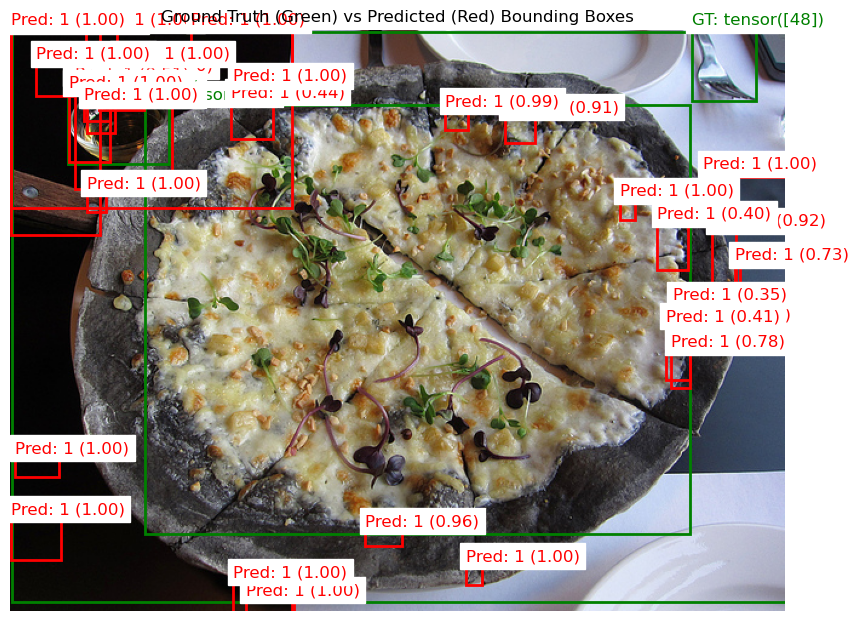

In [15]:

# Function to generate bounding boxes and classify them
def generate_and_classify_bounding_boxes(image_path, img_tensor, model, confidence_threshold=0.3, iou_threshold=0.7):
    model.eval()
    ss = cv2.ximgproc.segmentation.createSelectiveSearchSegmentation()
    image = cv2.imread(image_path)
    ss.setBaseImage(image)
    ss.switchToSelectiveSearchQuality()
    
    # Generate 200 bounding box proposals
    rects = ss.process()[:200]
    bounding_boxes = []

    for (x, y, w, h) in rects:
        # Ensure bounding box coordinates are valid
        if w <= 0 or h <= 0 or x < 0 or y < 0 or x + w > img_tensor.shape[3] or y + h > img_tensor.shape[2]:
            continue
        print((x,y,w,h))
        # Crop and resize the region of interest (ROI)
        roi = img_tensor[:, :, y:y + h, x:x + w]
        roi_resized = torch.nn.functional.interpolate(roi, size=(224, 224), mode='bilinear', align_corners=False).to(device)

        # Forward pass through the model
        outputs = model(roi_resized)
        probs = torch.softmax(outputs, dim=1)
        confidence, pred_label = torch.max(probs, 1)

        # Only consider proposals with confidence > 30%
        if confidence.item() > confidence_threshold:
            pred_box = coco_to_xyxy([x, y, w, h])
            print(f"Found: {pred_label}")
            # Check if the new box overlaps with existing ones and has the same classification
            should_add = True
            for box in bounding_boxes:
                existing_box = torch.tensor(box['bbox'], dtype=torch.float32).unsqueeze(0)
                new_box = torch.tensor(pred_box, dtype=torch.float32).unsqueeze(0)

                iou = box_iou(existing_box, new_box).item()

                if iou > iou_threshold and box['class'] == pred_label.item():
                    should_add = False
                    break  # Skip adding this box if similar one exists

            if should_add:
                bounding_boxes.append({
                    "bbox": pred_box,
                    "class": pred_label.item(),
                    "confidence": confidence.item()
                })

    return bounding_boxes


# Function to visualize predictions and ground truth bounding boxes
def visualize_predictions(image_path, img_tensor, model, target, confidence_threshold=0.3, iou_threshold=0.7):
    # Load the original image
    image = cv2.imread(image_path)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)  # Convert to RGB for plotting

    # Get ground truth bounding boxes and labels
    gt_boxes = [coco_to_xyxy(ann['bbox']) for ann in target]
    gt_labels = [ann['category_id'] for ann in target]

    # Generate predicted bounding boxes using the model
    predicted_boxes = generate_and_classify_bounding_boxes(image_path, img_tensor, model, confidence_threshold, iou_threshold)

    # Plot the image
    plt.figure(figsize=(10, 8))
    plt.imshow(image)

    # Plot ground truth boxes in green
    for box, label in zip(gt_boxes, gt_labels):
        x_min, y_min, x_max, y_max = box
        plt.gca().add_patch(plt.Rectangle((x_min, y_min), x_max - x_min, y_max - y_min,
                                          linewidth=2, edgecolor='green', facecolor='none'))
        plt.text(x_min, y_min - 5, f"GT: {label}", color='green', fontsize=12, backgroundcolor='white')

    # Plot predicted bounding boxes in red
    for pred in predicted_boxes:
        x_min, y_min, x_max, y_max = pred["bbox"]
        pred_class = pred["class"]
        confidence = pred["confidence"]
        
        plt.gca().add_patch(plt.Rectangle((x_min, y_min), x_max - x_min, y_max - y_min,
                                          linewidth=2, edgecolor='red', facecolor='none'))
        plt.text(x_min, y_min - 5, f"Pred: {pred_class} ({confidence:.2f})", 
                 color='red', fontsize=12, backgroundcolor='white')

    plt.axis('off')
    plt.title("Ground Truth (Green) vs Predicted (Red) Bounding Boxes")
    plt.show()

# Example usage
for img, target in train_loader:
    img = img.to(device)
    img_id = target[0]['image_id'].item()  # Get image ID
    img_path = full_dataset.coco.loadImgs(img_id)[0]['file_name']
    img_full_path = f"{coco_root}/{img_path}"

    # Call the visualization function
    visualize_predictions(img_full_path, img, model, target)

    break  # Process only the first image for demonstration

Clearly the training and validation has gone terribly wrong. The first thing we should do is redue the training.

In [ ]:
# Function to validate the model with sub-images from bounding boxes
def validate_model():
    model.eval()
    val_loss = 0.0
    with torch.no_grad():
        for img, target in val_loader:
            img = img.to(device)
            
            gt_boxes = [coco_to_xyxy(ann['bbox']) for ann in target]
            gt_labels = [ann['category_id'] for ann in target]

            accumulated_loss = 0.0  # Accumulate loss for proposals

            for (x_min, y_min, x_max, y_max), label in zip(gt_boxes, gt_labels):
                # Ensure bounding box coordinates are valid
                if x_max <= x_min or y_max <= y_min or x_min < 0 or y_min < 0 or x_max > img.shape[3] or y_max > img.shape[2]:
                    continue
                
                # Crop and resize the region of interest (ROI)
                roi = img[:, :, int(y_min):int(y_max), int(x_min):int(x_max)]
                roi_resized = torch.nn.functional.interpolate(roi.unsqueeze(0), size=(224, 224))

                # Forward pass through the model
                outputs = model(roi_resized)
                probs = torch.softmax(outputs, dim=1)
                confidence, pred_label = torch.max(probs, 1)

                # Convert ground truth label to tensor and move to device
                label_tensor = torch.tensor([label], dtype=torch.long).to(device)

                # Compute loss
                loss = criterion(outputs, label_tensor)
                accumulated_loss += loss.item()

            if accumulated_loss > 0:
                val_loss += accumulated_loss / len(gt_boxes)

    return val_loss / len(val_loader)

# Convert COCO bbox format [x, y, w, h] -> [x_min, y_min, x_max, y_max]
def coco_to_xyxy(box):
    x_min, y_min, width, height = box
    x_max = x_min + width
    y_max = y_min + height
    return [x_min, y_min, x_max, y_max]


def train_model(num_epochs=10, save_dir="/Users/ryanaschoff/Documents/COCO"):
    best_val_loss = float('inf')
    # Define image transformations (to be applied to cropped subimages)
    transform = transforms.Compose([
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    ])

    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0

        for imgs, targets in train_loader:  # Process a batch of images
            imgs = imgs.to(device)  # Move images to GPU

            optimizer.zero_grad()  # Zero gradients before processing proposals

            batch_rois = []
            batch_labels = []

            for img, target in zip(imgs, targets):
                # Extract ground truth bounding boxes and labels directly from tensors
                gt_boxes = target['bboxes'].to(device)
                gt_labels = target['labels'].to(device)

                min_size = 20  # Minimum acceptable height/width

                for (x_min, y_min, w, h), label in zip(gt_boxes, gt_labels):
                    x_min, y_min, w, h = int(x_min.item()), int(y_min.item()), int(w.item()), int(h.item())
                    x_max, y_max = x_min + w, y_min + h

                    # Ensure bounding box coordinates are valid and not too small
                    if w <= min_size or h <= min_size or x_min < 0 or y_min < 0 or x_max > img.shape[2] or y_max > img.shape[1]:
                        continue

                    # Crop the region of interest (ROI)
                    roi = img[:, y_min:y_max, x_min:x_max]

                    batch_rois.append(roi)
                    batch_labels.append(label.item())

            print(f"current labels are: {batch_labels}")

            # Stack ROIs and labels into a single batch
            # After collecting all ROIs, apply transformations to the entire batch at once
            if len(batch_rois) == 0:
                continue

            batch_rois = torch.stack(batch_rois).to(device)  # Stack tensors correctly
            batch_rois = transform(batch_rois)  # Apply transformations like resizing, normalization, etc.

            # Convert labels to tensor
            batch_labels = torch.tensor(batch_labels, dtype=torch.long).to(device)

            outputs = model(batch_rois)
            loss = criterion(outputs, batch_labels)
            running_loss += loss.item()

            loss.backward()  # Backpropagate accumulated loss
            optimizer.step()  # Update model after processing all proposals

        # Perform validation
        val_loss = validate_model()
        print(f"Epoch [{epoch+1}/{num_epochs}], Train Loss: {running_loss/len(train_loader):.4f}, Val Loss: {val_loss:.4f}")

        # Save best model
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            save_path = os.path.join(save_dir, 'resnet50_best.pth')
            torch.save(model.state_dict(), save_path)
            print(f"New best model saved to {save_path}")
        else:
            print("Early stopping, validation loss did not improve.")
            break

    print("Training complete.")

# Train the model
train_model()


Traceback (most recent call last):
  File "<string>", line 1, in <module>
  File "/Users/ryanaschoff/miniconda3/lib/python3.12/multiprocessing/spawn.py", line 122, in spawn_main
    exitcode = _main(fd, parent_sentinel)
               ^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/Users/ryanaschoff/miniconda3/lib/python3.12/multiprocessing/spawn.py", line 132, in _main
    self = reduction.pickle.load(from_parent)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
AttributeError: Can't get attribute 'custom_coco_transform' on <module '__main__' (<class '_frozen_importlib.BuiltinImporter'>)>


KeyboardInterrupt: 